In [1]:
import pandas as pd
from untrade.client import Client
from pprint import pprint

In [2]:
def process_data(data):
    # Calculate indicators
    data['SMA_20'] = data['close'].rolling(window=20).mean()  # 20-period simple moving average
    data['stddev'] = data['close'].rolling(window=20).std()   # 20-period standard deviation
    
    # Set the number of standard deviations for the upper and lower bands
    K = 2  # Typical Bollinger Bands use K=2
    
    # Calculate the upper and lower Bollinger Bands
    data['upper_band'] = data['SMA_20'] + (K * data['stddev'])
    data['lower_band'] = data['SMA_20'] - (K * data['stddev'])
    data.drop(['stddev'], axis=1, inplace=True)
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data["rsi"] = 100 - (100 / (1 + rs))
    # ema_short = data['close'].ewm(span=12, adjust=False).mean()
    # ema_long = data['close'].ewm(span=26, adjust=False).mean()
    # data["macd"] = ema_short - ema_long
    # data["signal_line"] = data["macd"].ewm(span=9, adjust=False).mean()
    data['high_low'] = data['high'] - data['low']
    data['high_close'] = abs(data['high'] - data['close'].shift(1))
    data['low_close'] = abs(data['low'] - data['close'].shift(1))
    data['true_range'] = data[['high_low', 'high_close', 'low_close']].max(axis=1)
    data['ATR'] = data['true_range'].ewm(span=14, adjust=False).mean() 

    # Generate buy/sell signals
    data["Signal"] = 0
    data.loc[(data['close'] > (data['close'].shift(1) + 1.5 * data['ATR'])) | (data['close'] < data['lower_band']) , "Signal"] = -1
    data.loc[(data['close'] < (data['close'].shift(1) - 1.5 * data['ATR'])) | (data['close'] > data['upper_band']) , "Signal"] = 1
    return data

In [3]:
def strat(data):
    signal = []
    prev = None
    for value in data["Signal"]:
        if value == prev:
            signal.append(0)
        else:
            signal.append(value)
        prev = value

    data["signals"] = signal
    return data

In [12]:
def perform_backtest(csv_file_path):
    # Create an instance of the untrade client
    client = Client()

    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="haricharan",  # Replace with your Jupyter ID used for login
        file_path=csv_file_path,
        leverage=1,  # Adjust leverage as needed
    )
    

    return result

In [13]:
if __name__ == "__main__":
    # Read data from CSV file
    data = pd.read_csv("BTC_1d.csv")  # Specify your data file path here

    # Process data
    res1 = process_data(data)

    # Apply strategy
    res = strat(res1)

    # Save processed data to CSV file
    res.to_csv("processed_data.csv", index=False)

    # Perform backtest on processed data
    csv_file_path = "processed_data.csv"
    backtest_result = perform_backtest(csv_file_path)

    # Get the last value of backtest result
    last_value = None
    for value in backtest_result:
        # Uncomment to see the full backtest result
        # print(value)
        last_value = value
    print(last_value)


547,
      "Sharpe Ratio": 3.074202,
      "Sortino Ratio": 16.972324,
      "To": "2024-01-01 00:00:00"
    },
    "compound_statistics": {
      "flag": "Trades Executed: 30",
      "Initial Balance": 1000.0,
      "Leverage Applied": 1.0,
      "Number of Trades": 30,
      "Profit Percentage": 101.377835,
      "Maximum Drawdown": 52.009678,
      "Average Drawdown": 28.03362,
      "Time to Recovery(TTR)": "405.000000 days",
      "Average TTR": "405.000000 days",
      "Maximum PNL": 3115.169334,
      "Minimum PNL": -1205.736931,
      "Max Portfolio Balance": 3986.027683,
      "Minimumm Portfolio Balance": 611.254782,
      "Final Balance": 2013.778354,
      "Total Fee": 104.35205
    }
  }
}




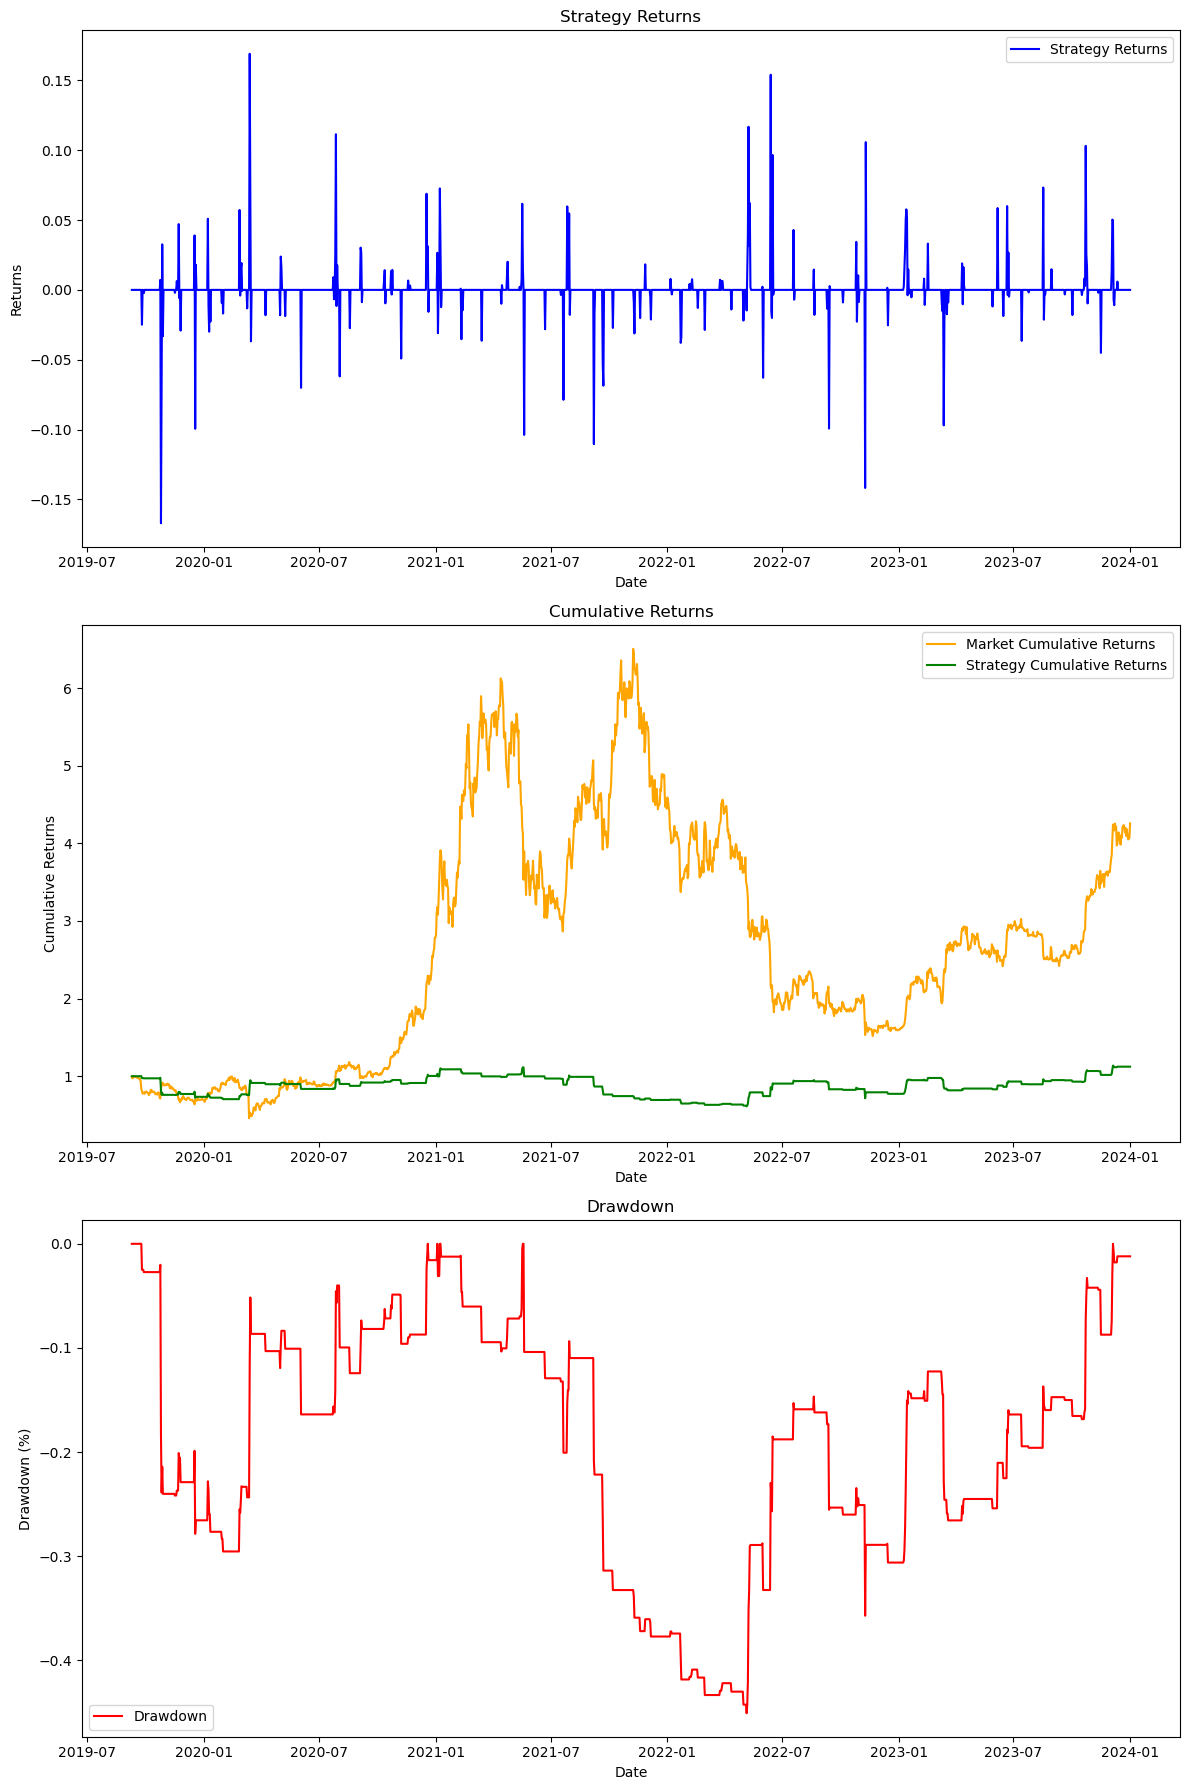

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("processed_data.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)


data['returns'] = data['close'].pct_change()
data['strategy_returns'] = data['Signal'].shift(1) * data['returns'] 

data['cumulative_market_returns'] = (1 + data['returns']).cumprod()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()

data['cum_max'] = data['cumulative_strategy_returns'].cummax()
data['drawdown'] = data['cumulative_strategy_returns'] / data['cumulative_strategy_returns'].cummax() - 1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))


ax1.plot(data.index, data['strategy_returns'], color="blue", label="Strategy Returns")
ax1.set_title("Strategy Returns")
ax1.set_xlabel("Date")
ax1.set_ylabel("Returns")
ax1.legend()

ax2.plot(data.index, data['cumulative_market_returns'], label="Market Cumulative Returns", color="orange")
ax2.plot(data.index, data['cumulative_strategy_returns'], label="Strategy Cumulative Returns", color="green")
ax2.set_title("Cumulative Returns")
ax2.set_xlabel("Date")
ax2.set_ylabel("Cumulative Returns")
ax2.legend()

# 3. Plot Drawdown
ax3.plot(data.index, data['drawdown'], color="red", label="Drawdown")
ax3.set_title("Drawdown")
ax3.set_xlabel("Date")
ax3.set_ylabel("Drawdown (%)")
ax3.legend()

plt.tight_layout()
plt.show()


In [15]:
if __name__ == "__main__":
    # Read data from CSV file
    data = pd.read_csv("ETH_1d.csv")  # Specify your data file path here

    # Process data
    res1 = process_data(data)

    # Apply strategy
    res = strat(res1)

    # Save processed data to CSV file
    res.to_csv("1dayATR.csv", index=False)

    # Perform backtest on processed data
    csv_file_path = "1dayATR.csv"
    backtest_result = perform_backtest(csv_file_path)

    # Get the last value of backtest result
    last_value = None
    for value in backtest_result:
        # Uncomment to see the full backtest result
        # print(value)
        last_value = value
    print(last_value)


8.560348,
      "Sharpe Ratio": 4.276485,
      "Sortino Ratio": 18.229136,
      "To": "2024-01-01 00:00:00"
    },
    "compound_statistics": {
      "flag": "Trades Executed: 23",
      "Initial Balance": 1000.0,
      "Leverage Applied": 1.0,
      "Number of Trades": 23,
      "Profit Percentage": 184.772476,
      "Maximum Drawdown": 69.244392,
      "Average Drawdown": 28.492164,
      "Time to Recovery(TTR)": "182.000000 days",
      "Average TTR": "159.000000 days",
      "Maximum PNL": 3933.963254,
      "Minimum PNL": -2548.181965,
      "Max Portfolio Balance": 9077.624955,
      "Minimumm Portfolio Balance": 1000.0,
      "Final Balance": 2847.724759,
      "Total Fee": 153.710935
    }
  }
}




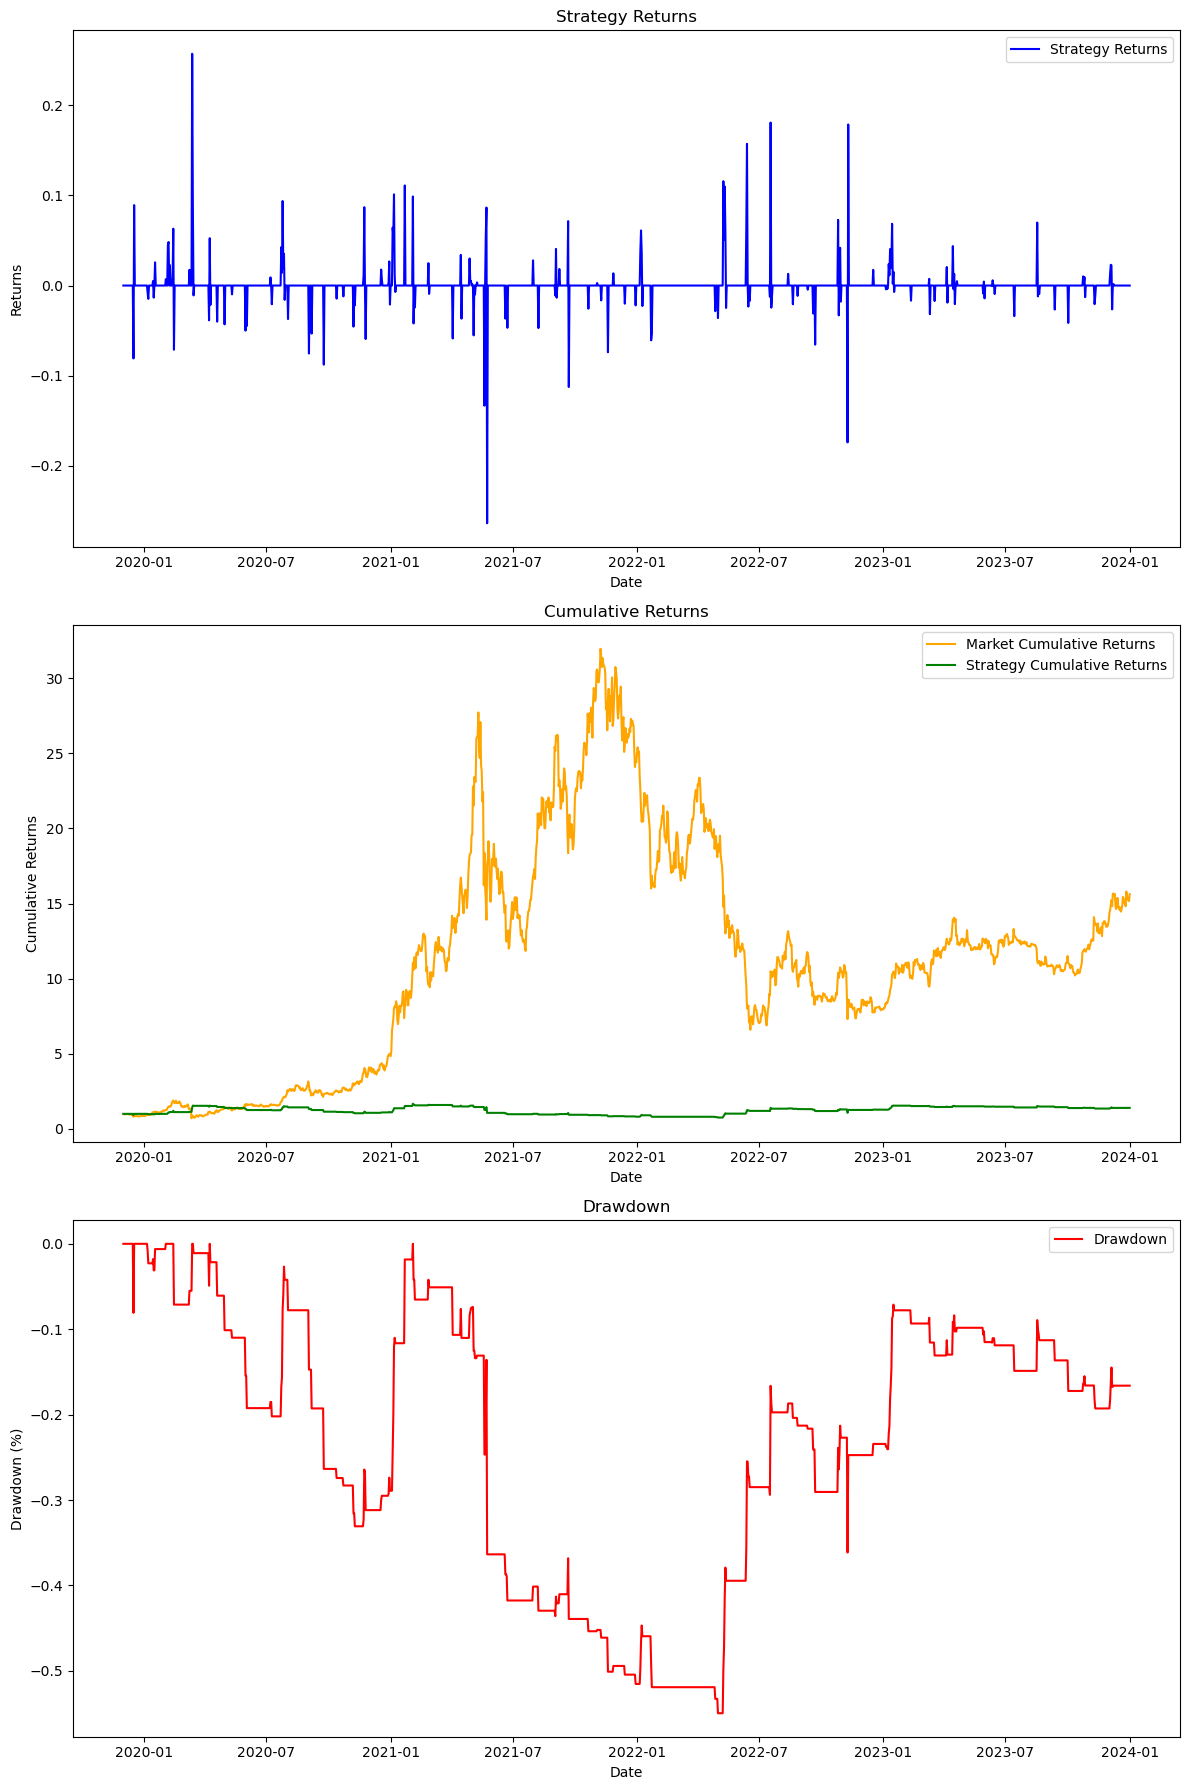

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("1dayATR.csv")
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)


data['returns'] = data['close'].pct_change()
data['strategy_returns'] = data['Signal'].shift(1) * data['returns'] 

data['cumulative_market_returns'] = (1 + data['returns']).cumprod()
data['cumulative_strategy_returns'] = (1 + data['strategy_returns']).cumprod()

data['cum_max'] = data['cumulative_strategy_returns'].cummax()
data['drawdown'] = data['cumulative_strategy_returns'] / data['cumulative_strategy_returns'].cummax() - 1

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))


ax1.plot(data.index, data['strategy_returns'], color="blue", label="Strategy Returns")
ax1.set_title("Strategy Returns")
ax1.set_xlabel("Date")
ax1.set_ylabel("Returns")
ax1.legend()

ax2.plot(data.index, data['cumulative_market_returns'], label="Market Cumulative Returns", color="orange")
ax2.plot(data.index, data['cumulative_strategy_returns'], label="Strategy Cumulative Returns", color="green")
ax2.set_title("Cumulative Returns")
ax2.set_xlabel("Date")
ax2.set_ylabel("Cumulative Returns")
ax2.legend()

# 3. Plot Drawdown
ax3.plot(data.index, data['drawdown'], color="red", label="Drawdown")
ax3.set_title("Drawdown")
ax3.set_xlabel("Date")
ax3.set_ylabel("Drawdown (%)")
ax3.legend()

plt.tight_layout()
plt.show()
